In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import SPSA,COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

In [8]:
data = pd.read_csv('/Users/rishivarshilnelakurti/Documents/AP Research Project/higgs-boson/training.csv')
data.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [9]:
features = data[['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'
       ]]
# number of qubits is equal to 10
num_qubits = len(features.columns) # MOD 1 higher number of qubits


features = features.loc[0:100, :].to_numpy()
features = MinMaxScaler().fit_transform(features)

labels = data['Label']
labels = labels.loc[0:100].to_numpy()

features = PCA(n_components=num_qubits).fit_transform(features)


train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, shuffle=False
)

In [10]:
# create a feature map
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1) # MOD 2 entangling feature map
# create a variational circuit
ansatz = RealAmplitudes(num_qubits)

# combine feature map and ansatz into a single circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))

In [11]:
def convertlabels(labels):
    for x in np.nditer(labels,flags=["refs_ok"], op_flags=['readwrite']):
        if x == 's':
            x[...] = int(1)
        else:
            x[...] = int(-1)
    return labels

train_labels = convertlabels(train_labels)
test_labels = convertlabels(test_labels)

In [12]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [13]:
estimator_qnn.forward(train_features.astype(int), algorithm_globals.random.random(estimator_qnn.num_weights))

KeyboardInterrupt: 

In [14]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
# construct classifier
initial_point = algorithm_globals.random.random(estimator_qnn.num_weights)

estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=SPSA(maxiter=80), # MOD 3 type of optimizer
    initial_point=initial_point,
    callback=callback_graph,
)
# create empty array for callback to store evaluations of the objective function (callback)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
# fit classifier to data
estimator_classifier.fit(train_features.astype(int), train_labels.astype(int))

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [166]:
estimator_classifier.score(test_features.astype(int), test_labels.astype(int))

0.7307692307692307

In [170]:
from sklearn.metrics import classification_report

predicts = estimator_classifier.predict(test_features.astype(int))
x = classification_report(test_labels.astype(int), predicts.astype(int))
print(x)

              precision    recall  f1-score   support

          -1       0.73      1.00      0.84        19
           1       0.00      0.00      0.00         7

    accuracy                           0.73        26
   macro avg       0.37      0.50      0.42        26
weighted avg       0.53      0.73      0.62        26



/Users/rishivarshilnelakurti/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishivarshilnelakurti/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishivarshilnelakurti/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [171]:
import math
from sklearn.metrics import roc_curve

b, s, thresholds = roc_curve(test_labels.astype(int), probs[:,0])
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print ('radicand is negative. Exiting')
        exit()
    else:
        return math.sqrt(radicand)


In [183]:
FP = 0;
TP = 0;
TN = 0;
FN = 0;
train_predicts = estimator_classifier.predict(train_features.astype(int))

for i in range(len(train_predicts)):
    if(train_predicts[i] == 1):
        if(train_labels[i] == -1):
            FP=FP+1;
    if(train_predicts[i] == train_labels[i]):
        TP=TP+1;
for i in range(len(predicts)):
    if(train_predicts[i] == -1):
        if(train_labels[i] == -1):
            TN=TN+1;
    if(train_predicts[i] == -1):
        if(train_labels[i] == 1):
            FN=FN+1;

     
fpr = FP/(FP+TN)
tpr = TP/(TP+FN)
AMS(tpr,fpr)

0.2691936772292623

0.6353383458646616


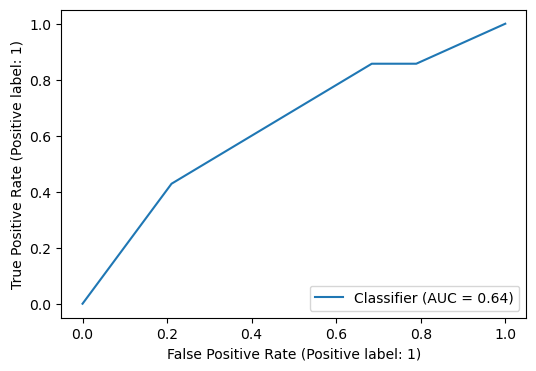

In [185]:
from sklearn.metrics import roc_auc_score
probs = estimator_qnn.forward(test_features.astype(int), algorithm_globals.random.random(estimator_qnn.num_weights))
plot = RocCurveDisplay.from_predictions(test_labels.astype(int), probs[:,0])
print(roc_auc_score(test_labels.astype(int), probs[:,0]))
plt.show()

In [94]:
from sklearn.datasets import make_classification

num_inputs = 15
num_samples = 50

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_inputs,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
)
X = MinMaxScaler().fit_transform(X)
y = 2 * y - 1  # labels in {-1, 1}

num_qubits = 15
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=1)

# combine feature map and ansatz into a single circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))